First we need to import the following packages.

In [1]:
import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Data import CodonTable
from Bio.SeqRecord import SeqRecord
import pandas as pd

from Bio.SeqUtils.ProtParam import ProteinAnalysis

Below is a function to extract fasta sequences

In [2]:
def get_sequences_from_file(fasta_fn): #pull in the information from seq file
    sequence_data_dict = {}
    for record in SeqIO.parse(fasta_fn, "fasta"):
        description = record.description.split()
        species_name = description[1] + " " + description[2]
        sequence_data_dict[species_name] = record.seq
    return(sequence_data_dict) # gives a dictionary with species name and decription, matched to seq. fasta

#### Translation (#2)

The function below creats an amino acid string.

In [3]:
def translate_function(string_nuc): 
    mitoch_table = CodonTable.unambiguous_dna_by_name["Vertebrate Mitochondrial"] 
    aa_string = [] # starts the amino acid string
    for i in range(0, len(string_nuc),3):
        codon = string_nuc[i:i +3] # adds 3 nucleotides 
        
        if codon == 'AGA' or codon == 'AGG' or codon == 'TAG' or codon == 'TAA' : # looks for stop codons
            break #stops when it hits a stop codons 
        else:
            aa = mitoch_table.forward_table[codon] # pulls a.a. from table
            aa_string.append(aa) # adds a.a. to the string    
       
    return "".join(aa_string) # returns a string of sequence

In [4]:
mitoch_table = CodonTable.unambiguous_dna_by_name["Vertebrate Mitochondrial"] 
print(mitoch_table) # way to visualize the codon table

Table 2 Vertebrate Mitochondrial, SGC1

  |  T      |  C      |  A      |  G      |
--+---------+---------+---------+---------+--
T | TTT F   | TCT S   | TAT Y   | TGT C   | T
T | TTC F   | TCC S   | TAC Y   | TGC C   | C
T | TTA L   | TCA S   | TAA Stop| TGA W   | A
T | TTG L   | TCG S   | TAG Stop| TGG W   | G
--+---------+---------+---------+---------+--
C | CTT L   | CCT P   | CAT H   | CGT R   | T
C | CTC L   | CCC P   | CAC H   | CGC R   | C
C | CTA L   | CCA P   | CAA Q   | CGA R   | A
C | CTG L   | CCG P   | CAG Q   | CGG R   | G
--+---------+---------+---------+---------+--
A | ATT I(s)| ACT T   | AAT N   | AGT S   | T
A | ATC I(s)| ACC T   | AAC N   | AGC S   | C
A | ATA M(s)| ACA T   | AAA K   | AGA Stop| A
A | ATG M(s)| ACG T   | AAG K   | AGG Stop| G
--+---------+---------+---------+---------+--
G | GTT V   | GCT A   | GAT D   | GGT G   | T
G | GTC V   | GCC A   | GAC D   | GGC G   | C
G | GTA V   | GCA A   | GAA E   | GGA G   | A
G | GTG V(s)| GCG A   | GAG E   | GGG G   

There is a much simpler way to go about doing this (#3)

In [5]:
def translate(string_nuc): 
    amino_acid = Seq.translate(string_nuc, table="Vertebrate Mitochondrial", to_stop=True) #uses Bio.Seq to quickly translate the codons based on V.M. table
    return str(amino_acid) 


molecular weight analysis (#4)

In [6]:
       
def calculate_MW(amino_acid_seq): #creating the function 
    molecular_weight = ProteinAnalysis(amino_acid_seq).molecular_weight() # calculate MW from Protein sequence
    return molecular_weight

GC content check (#5)

script below calculates the C and G content of the seq. 

In [7]:
cytb_seqs = get_sequences_from_file("penguins_cytb.fasta") 
penguins_df = pd.read_csv("penguins_mass.csv") # Includes only data for body mass 
species_list = list(penguins_df.species)

In [8]:
def GC_content(DNA_string):
    Gcount = DNA_string.count("G") # counts the "G"s
    Ccount = DNA_string.count("C") # counts the "C"s
    DNAstring_length = len(DNA_string) # defines DNAstring_length as the length of the DNA_string
    GC_content = (Ccount+Gcount)/DNAstring_length # divide the total of G and C by the totality 
    return GC_content

In [9]:
print(penguins_df)

                    species   mass
0      Aptenodytes forsteri  28.00
1   Aptenodytes patagonicus  13.40
2       Eudyptes chrysocome   2.80
3     Eudyptes chrysolophus   4.50
4         Eudyptes sclateri   4.25
5           Eudyptula minor   1.60
6        Pygoscelis adeliae   4.60
7     Pygoscelis antarctica   4.10
8          Pygoscelis papua   6.10
9       Spheniscus demersus   3.20
10     Spheniscus humboldti   4.75
11  Spheniscus magellanicus   3.40


Next we will add two columns for the MW and the GC content

In [10]:
penguins_mass_extended = penguins_df.assign(molecular_weight = 'NaN', GC_content='NaN') # adds the columns to the table
print(penguins_mass_extended)

                    species   mass molecular_weight GC_content
0      Aptenodytes forsteri  28.00              NaN        NaN
1   Aptenodytes patagonicus  13.40              NaN        NaN
2       Eudyptes chrysocome   2.80              NaN        NaN
3     Eudyptes chrysolophus   4.50              NaN        NaN
4         Eudyptes sclateri   4.25              NaN        NaN
5           Eudyptula minor   1.60              NaN        NaN
6        Pygoscelis adeliae   4.60              NaN        NaN
7     Pygoscelis antarctica   4.10              NaN        NaN
8          Pygoscelis papua   6.10              NaN        NaN
9       Spheniscus demersus   3.20              NaN        NaN
10     Spheniscus humboldti   4.75              NaN        NaN
11  Spheniscus magellanicus   3.40              NaN        NaN


 Get GC-content and amino acid molecular weight and loop into a dataframe

In [11]:
for key, value in cytb_seqs.items(): 
    aa_seq = translate_function(value) # does the translation
    molecular_weight = calculate_MW(aa_seq) #calculates the MW
    GC_percentage = GC_content(value)*100 # Turns into a percentage
    
    for index, row in penguins_mass_extended.iterrows():
        if row['species'] == key: #points to the species to add MW and GC
            penguins_mass_extended.loc[index, 'molecular_weight'] = molecular_weight 
            penguins_mass_extended.loc[index, 'GC_content'] = GC_percentage

In [12]:
penguins_mass_extended

,species,mass,molecular_weight,GC_content
0,Aptenodytes forsteri,28.00,42459.6021,48.381452
1,Aptenodytes patagonicus,13.40,42563.7067,49.693788
2,Eudyptes chrysocome,2.80,42475.5753,51.181102
3,Eudyptes chrysolophus,4.50,42445.5493,50.918635
4,Eudyptes sclateri,4.25,42475.5753,50.831146
5,Eudyptula minor,1.60,42491.6408,49.256343
6,Pygoscelis adeliae,4.60,42458.614,49.081365
7,Pygoscelis antarctica,4.10,42404.5423,47.769029
8,Pygoscelis papua,6.10,42595.8759,47.156605
9,Spheniscus demersus,3.20,42431.549,48.293963


### Visualization

First a plot for the mass of each species (#8).

<AxesSubplot:title={'center':'mass of species'}, xlabel='species'>

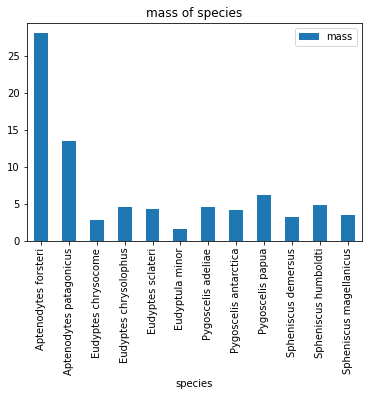

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
penguins_mass_extended.plot(kind = 'bar', x = 'species', y = 'mass', title = 'mass of species')

question number 8 = Eudyptula minor, whos geographic range is Australia and New Zealand

Below is a script to analyze the relationship between GC content and molecular weight. 

<AxesSubplot:title={'center':'molecular weight (y-axis) as a function of GC-content (x-axis)'}, xlabel='GC_content', ylabel='molecular_weight'>

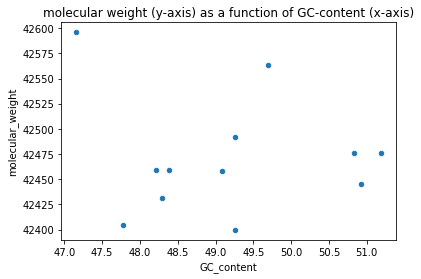

In [14]:
x_data = GC_percentage
y_data = molecular_weight

penguins_mass_extended.plot(kind='scatter',x="GC_content",y="molecular_weight", title='molecular weight (y-axis) as a function of GC-content (x-axis)')

Save the new table to a new csv file.

In [ ]:
penguins_mass_extended.to_csv("penguins_mass_cytb.csv", index=False)